In [2]:
import pandas
import pandas as pd
import numpy as np
import sqlite3

In [3]:
# twm_accounts = pd.read_csv('data/clean/twm_accounts.csv')
# twm_customer = pd.read_csv('data/clean/twm_customer.csv')
# twm_transactions = pd.read_csv('data/clean/twm_transactions.csv')
# twm_checking_acct = pd.read_csv('data/clean/twm_checking_acct.csv')
# twm_checking_tran = pd.read_csv('data/clean/twm_checking_tran.csv')
# twm_credit_acct = pd.read_csv('data/clean/twm_credit_acct.csv')
# twm_credit_tran = pd.read_csv('data/clean/twm_credit_tran.csv')
# twm_savings_acct = pd.read_csv('data/clean/twm_savings_acct.csv')
# twm_savings_tran = pd.read_csv('data/clean/twm_savings_tran.csv')

In [59]:
def dummy_var_create(df, column_name):
    for name in set(df[column_name]):
        if str(name).strip() != "" and name != None:
            df[f"{column_name}_dummy_{name}"] = (df[column_name] == name).astype(int)

# twm_transactions2 = pd.DataFrame(twm_transactions)


In [60]:
# dummy_var_create(twm_accounts, "acct_type")
# dummy_var_create(twm_accounts, "account_active")
# dummy_var_create(twm_transactions, "channel")
# dummy_var_create(twm_transactions, "tran_code")
#
#


In [212]:
sql_query = """
SELECT cust_id, acct_nbr, tran_id, acct_type, nbr_of_accts, nbr_of_trans, tran_date_max, tran_date_min, acct_active,acct_start_date,acct_end_date,
        tran_date, AVG(tran_amt) AS avg_tran_amt,
       starting_balance as acct_initial_balance,ending_balance as acct_final_balance
           FROM
twm_transactions
INNER JOIN
(
SELECT twm_accounts.cust_id,
       twm_accounts.acct_nbr as __acct_nbr,
       nbr_of_accts,
       nbr_of_trans,
       tran_date_max,
       tran_date_min,
       acct_type,
       CASE
           WHEN account_active = "N" THEN 0
           ELSE 1
           END                           AS acct_active,
       starting_balance,
       ending_balance,
       ending_balance - starting_balance AS delta_balance,
       acct_start_date,
       CASE
           WHEN acct_end_date IS TRUE THEN acct_end_date
           ELSE '1996-01-01'
           END                           AS acct_end_date

FROM twm_accounts
         INNER JOIN (SELECT cust_id                     as me_cust_id,
                            COUNT(twm_accounts.cust_id) AS nbr_of_accts
                     FROM twm_accounts
                     GROUP BY me_cust_id)
                    ON twm_accounts.cust_id = me_cust_id

         INNER JOIN (SELECT acct_nbr        as _acct_nbr,
                            COUNT(acct_nbr) AS nbr_of_trans,
                            MAX(tran_date) AS tran_date_max,
                            MIN(tran_date) AS tran_date_min
                     FROM twm_transactions
                     GROUP BY _acct_nbr)
                    ON twm_accounts.acct_nbr = _acct_nbr )


ON twm_transactions.acct_nbr = __acct_nbr
GROUP BY cust_id, acct_type
ORDER BY cust_id, __acct_nbr;
"""

In [213]:
with sqlite3.connect("data/twm.db") as conn:
    twm_data = pd.read_sql(sql_query, con=conn)
    twm_data.acct_nbr = twm_data.acct_nbr.astype(int)

In [214]:
twm_data2 = pd.DataFrame(twm_data)
# twm_data2['acct_start_date'] = pd.to_datetime(twm_data2['acct_start_date'])
# twm_data2['acct_end_date'] = pd.to_datetime(twm_data2['acct_end_date'])
# twm_data2['tran_date'] = pd.to_datetime(twm_data['tran_date'])

# twm_data2['acct_start_date'].to_timestamp()

In [215]:
dummy_var_create(twm_data2, "acct_type")
# dummy_var_create(twm_data2, "channel")
# dummy_var_create(twm_data2, "tran_code")

In [216]:
twm_data2.columns

Index(['cust_id', 'acct_nbr', 'tran_id', 'acct_type', 'nbr_of_accts',
       'nbr_of_trans', 'tran_date_max', 'tran_date_min', 'acct_active',
       'acct_start_date', 'acct_end_date', 'tran_date', 'avg_tran_amt',
       'acct_initial_balance', 'acct_final_balance', 'acct_type_dummy_CC',
       'acct_type_dummy_SV', 'acct_type_dummy_CK'],
      dtype='object')

In [236]:
import datetime

# columns for if each customer has a certain account type
twm_data2['has_CC'] = twm_data2['acct_type_dummy_CC']
twm_data2['has_CK'] = twm_data2['acct_type_dummy_CK']
twm_data2['has_SV'] = twm_data2['acct_type_dummy_SV']

# columns for start and end date of account by type
twm_data2['acct_start_date_CC'] = twm_data2['acct_start_date'] * twm_data2['acct_type_dummy_CC']
twm_data2['acct_start_date_CC'] = twm_data2['acct_start_date_CC'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['acct_end_date_CC'] = twm_data2['acct_end_date'] * twm_data2['acct_type_dummy_CC']
twm_data2['acct_end_date_CC'] = twm_data2['acct_end_date_CC'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)

twm_data2['acct_start_date_CK'] = twm_data2['acct_start_date'] * twm_data2['acct_type_dummy_CK']
twm_data2['acct_start_date_CK'] = twm_data2['acct_start_date_CK'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)

twm_data2['acct_end_date_CK'] = twm_data2['acct_end_date'] * twm_data2['acct_type_dummy_CK']
twm_data2['acct_end_date_CK'] = twm_data2['acct_end_date_CK'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)

twm_data2['acct_start_date_SV'] = twm_data2['acct_start_date'] * twm_data2['acct_type_dummy_SV']
twm_data2['acct_start_date_SV'] = twm_data2['acct_start_date_SV'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)

twm_data2['acct_end_date_SV'] = twm_data2['acct_end_date'] * twm_data2['acct_type_dummy_SV']
twm_data2['acct_end_date_SV'] = twm_data2['acct_end_date_SV'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)

# calculating length of account life in days for each type of account
twm_data2['acct_term_CC'] = (
        (pd.to_datetime(twm_data2['acct_end_date']) - pd.to_datetime(twm_data2['acct_start_date'])) * twm_data2[
    'acct_type_dummy_CC'])
twm_data2['acct_term_CC'] = twm_data2['acct_term_CC'].map(lambda tm: tm.days)

twm_data2['acct_term_CK'] = (
        (pd.to_datetime(twm_data2['acct_end_date']) - pd.to_datetime(twm_data2['acct_start_date'])) * twm_data2[
    'acct_type_dummy_CK'])
twm_data2['acct_term_CK'] = twm_data2['acct_term_CK'].map(lambda tm: tm.days)

twm_data2['acct_term_SV'] = (
        (pd.to_datetime(twm_data2['acct_end_date']) - pd.to_datetime(twm_data2['acct_start_date'])) * twm_data2[
    'acct_type_dummy_SV'])
twm_data2['acct_term_SV'] = twm_data2['acct_term_SV'].map(lambda tm: tm.days)

# creating tran date max/min columns for each different account type
twm_data2['tran_date_max_CC'] = twm_data2['tran_date_max'] * twm_data2['acct_type_dummy_CC']
twm_data2['tran_date_max_CC'] = twm_data2['tran_date_max_CC'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_min_CC'] = twm_data2['tran_date_min'] * twm_data2['acct_type_dummy_CC']
twm_data2['tran_date_min_CC'] = twm_data2['tran_date_min_CC'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_range_CC'] = twm_data2['tran_date_max_CC'] - twm_data2['tran_date_min_CC']

twm_data2['tran_date_max_CK'] = twm_data2['tran_date_max'] * twm_data2['acct_type_dummy_CK']
twm_data2['tran_date_max_CK'] = twm_data2['tran_date_max_CK'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_min_CK'] = twm_data2['tran_date_min'] * twm_data2['acct_type_dummy_CK']
twm_data2['tran_date_min_CK'] = twm_data2['tran_date_min_CK'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_range_CK'] = twm_data2['tran_date_max_CK'] - twm_data2['tran_date_min_CK']

twm_data2['tran_date_max_SV'] = twm_data2['tran_date_max'] * twm_data2['acct_type_dummy_SV']
twm_data2['tran_date_max_SV'] = twm_data2['tran_date_max_SV'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_min_SV'] = twm_data2['tran_date_min'] * twm_data2['acct_type_dummy_SV']
twm_data2['tran_date_min_SV'] = twm_data2['tran_date_min_SV'].map(
    lambda x: (pd.to_datetime(x) - datetime.datetime(1970, 1, 1)).days)
twm_data2['tran_date_range_SV'] = twm_data2['tran_date_max_SV'] - twm_data2['tran_date_min_SV']

# columns for avg tran amt by account type
twm_data2['avg_tran_amt_CC'] = twm_data['avg_tran_amt'] * twm_data2['acct_type_dummy_CC']
twm_data2['avg_tran_amt_CK'] = twm_data['avg_tran_amt'] * twm_data2['acct_type_dummy_CK']
twm_data2['avg_tran_amt_SV'] = twm_data['avg_tran_amt'] * twm_data2['acct_type_dummy_SV']

# columns for number of transactions by acct type
twm_data2['nbr_of_tran_CC'] = twm_data['nbr_of_trans'] * twm_data2['acct_type_dummy_CC']
twm_data2['nbr_of_tran_CK'] = twm_data['nbr_of_trans'] * twm_data2['acct_type_dummy_CK']
twm_data2['nbr_of_tran_SV'] = twm_data['nbr_of_trans'] * twm_data2['acct_type_dummy_SV']

# new columns for initial and final bank balance by account type
twm_data2['acct_initial_balance_CC'] = twm_data['acct_initial_balance'] * twm_data2['acct_type_dummy_CC']
twm_data2['acct_final_balance_CC'] = twm_data['acct_final_balance'] * twm_data2['acct_type_dummy_CC']
twm_data2['acct_balance_change_CC'] = twm_data['acct_final_balance_CC'] - twm_data2['acct_initial_balance_CC']

twm_data2['acct_initial_balance_CK'] = twm_data['acct_initial_balance'] * twm_data2['acct_type_dummy_CK']
twm_data2['acct_final_balance_CK'] = twm_data['acct_final_balance'] * twm_data2['acct_type_dummy_CK']
twm_data2['acct_balance_change_CK'] = twm_data['acct_final_balance_CK'] - twm_data2['acct_initial_balance_CK']

twm_data2['acct_initial_balance_SV'] = twm_data['acct_initial_balance'] * twm_data2['acct_type_dummy_SV']
twm_data2['acct_final_balance_SV'] = twm_data['acct_final_balance'] * twm_data2['acct_type_dummy_SV']
twm_data2['acct_balance_change_SV'] = twm_data['acct_final_balance_SV'] - twm_data2['acct_initial_balance_SV']

twm_data2['days_per_tran_CC'] = twm_data2['tran_date_range_CC'] // twm_data2['nbr_of_tran_CC']
twm_data2['days_per_tran_CK'] = twm_data2['tran_date_range_CK'] // twm_data2['nbr_of_tran_CK']
twm_data2['days_per_tran_SV'] = twm_data2['tran_date_range_SV'] // twm_data2['nbr_of_tran_SV']

# twm_data2['days_per_transaction_SV'] = twm_data

twm_data2.columns

Index(['cust_id', 'acct_nbr', 'tran_id', 'acct_type', 'nbr_of_accts',
       'nbr_of_trans', 'tran_date_max', 'tran_date_min', 'acct_active',
       'acct_start_date', 'acct_end_date', 'tran_date', 'avg_tran_amt',
       'acct_initial_balance', 'acct_final_balance', 'acct_type_dummy_CC',
       'acct_type_dummy_SV', 'acct_type_dummy_CK', 'has_CC', 'has_CK',
       'has_SV', 'acct_start_date_CC', 'acct_end_date_CC',
       'acct_start_date_CK', 'acct_end_date_CK', 'acct_start_date_SV',
       'acct_end_date_SV', 'acct_term_CC', 'acct_term_CK', 'acct_term_SV',
       'tran_date_max_CC', 'tran_date_min_CC', 'tran_date_range_CC',
       'tran_date_max_CK', 'tran_date_min_CK', 'tran_date_range_CK',
       'tran_date_max_SV', 'tran_date_min_SV', 'tran_date_range_SV',
       'avg_tran_amt_CC', 'avg_tran_amt_CK', 'avg_tran_amt_SV',
       'nbr_of_tran_CC', 'nbr_of_tran_CK', 'nbr_of_tran_SV',
       'acct_initial_balance_CC', 'acct_final_balance_CC',
       'acct_balance_change_CC', 'acct_initi

In [290]:
twm_data3 = pd.DataFrame(twm_data2)
twm_data3 = twm_data3.groupby('cust_id')['has_CC', 'has_CK', 'has_SV',
                                         'acct_term_CC',
                                         'acct_term_CK',
                                         'acct_term_SV',
                                         'avg_tran_amt_CC', 'avg_tran_amt_CK', 'avg_tran_amt_SV',
                                         'days_per_tran_CC', 'days_per_tran_CK', 'days_per_tran_SV',
                                         'acct_balance_change_CC', 'acct_balance_change_CK',
                                         'acct_balance_change_SV'].apply(sum)

# twm_data3 = twm_data3.groupby('cust_id')[
#     'acct_term_CC',
#     'acct_term_CK',
#     'acct_term_SV',
#     'avg_tran_amt_CC', 'avg_tran_amt_CK', 'avg_tran_amt_SV',
#     'days_per_tran_CC', 'days_per_tran_CK', 'days_per_tran_SV',
#     'acct_initial_balance_CC', 'acct_final_balance_CC',
#     'acct_initial_balance_CK', 'acct_final_balance_CK',
#     'acct_initial_balance_SV', 'acct_final_balance_SV'].apply(sum)

# twm_data3 = twm_data3.groupby('cust_id')[
#     'avg_tran_amt_CC', 'avg_tran_amt_CK', 'avg_tran_amt_SV',
#     'nbr_of_tran_CC', 'nbr_of_tran_CK', 'nbr_of_tran_SV'].apply(sum)

# dropme = ['acct_nbr', 'tran_id', 'acct_type', 'acct_start_date', 'avg_tran_amt','acct_end_date', 'tran_date', 'acct_final_balance']
# twm_data3 = twm_data3.drop(columns=dropme)
# for i in dropme:
#     twm_data3 = twm_data3.drop(columns=i)

# twm_data3['cust_id'] = twm_data3['cust_id'].astype(object)

# = twm_data3.drop('cust_id')

/tmp/ipykernel_1472226/297100493.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [291]:
twm_data4 = pd.DataFrame(twm_data3)

In [306]:
from sklearn.cluster import AgglomerativeClustering

import scipy.cluster.hierarchy as sch

# create an Agglomerative Clustering object
ac = AgglomerativeClustering(affinity='euclidean',
                             linkage='ward',
                             n_clusters=3)

hc = ac.fit_predict(twm_data4)

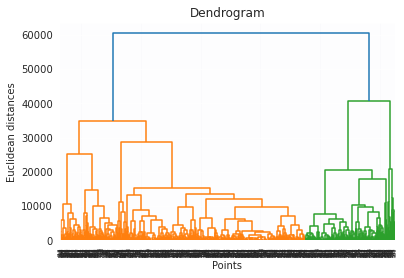

In [307]:
# define plot_dendrogram function
import matplotlib.pyplot as plt


def plot_dendrogram(X, method='ward'):
    dendrogram = sch.dendrogram(sch.linkage(X, method=method))
    plt.title("Dendrogram")
    plt.ylabel("Euclidean distances")
    plt.xlabel('Points')
    plt.show()


plot_dendrogram(twm_data4)

In [308]:
from sklearn.cluster import KMeans

km = KMeans(3).fit(twm_data4)
# km = KMeans(3, init='k-means++').fit(twm_data4)


In [309]:
the_df = pd.DataFrame(twm_data3.index)
the_df['km_clusters'] = km.labels_
the_df['hc_clusters'] = hc

cluster_df = pd.DataFrame(the_df)
# cluster_df['km_clusters'] = (cluster_df['km_clusters'] + 2) % 5

# cluster_df.loc[cluster_df.hc_clusters == 4, 'hc_clusters'] = 1
# cluster_df.loc[cluster_df.km_clusters == 1, 'km_clusters'] = 4

cluster_df['same_cluster'] = cluster_df['km_clusters'] == cluster_df['hc_clusters']
cluster_df['same_cluster'] = cluster_df['same_cluster'].astype(int)

cluster_df = pd.DataFrame(cluster_df)

In [310]:
# dummy_km = pd.get_dummies(km.labels_)
# dummy_hc = pd.get_dummies(hc)

In [311]:
# the_df.rename(columns={0: 'cust_id', 'Unnamed 0': 'agglo_clusters', 'Unnamed 1': 'km_clusters'})



In [312]:
import plotly.express as px
import plotly.graph_objects as go

In [313]:

twm_data5 = pd.DataFrame(twm_data3)
# twm_data5 = pd.DataFrame()
final_df = cluster_df.join(twm_data5, on='cust_id', how='left')

final_df = final_df.set_index('cust_id')


In [314]:
final_df.drop('same_cluster', axis=1)
final_df['km_clusters'] = final_df['km_clusters'].astype(str)
final_df['hc_clusters'] = final_df['hc_clusters'].astype(str)
final_df.to_csv('data/out/cluster_df.csv', sep=',')


In [316]:
px.scatter(final_df, y='days_per_tran_SV', x='avg_tran_amt_SV', color='km_clusters')
px.scatter(final_df, y='days_per_tran_SV', x='avg_tran_amt_SV', color='hc_clusters')


In [317]:
px.scatter(final_df, y='days_per_tran_CK', x='avg_tran_amt_CK', color='km_clusters')
px.scatter(final_df, y='days_per_tran_CK', x='avg_tran_amt_CK', color='hc_clusters')



In [318]:
px.scatter(final_df, y='days_per_tran_CC', x='avg_tran_amt_CC', color='km_clusters')
px.scatter(final_df, y='days_per_tran_CC', x='avg_tran_amt_CC', color='hc_clusters')


In [142]:
px.scatter_3d(final_df, x='avg_tran_amt_CC', y='avg_tran_amt_CK', z='avg_tran_amt_SV', color='hc_clusters',
              size=(final_df.nbr_of_tran_CC + final_df.nbr_of_tran_CK + final_df.nbr_of_tran_SV))

In [157]:
from sklearn.decomposition import PCA

pca1 = PCA(whiten=True)
pca1.fit_transform(twm_data5)

array([[ 0.71797514,  0.07833046,  0.14099536, ...,  0.07327235,
        -0.9099763 ,  0.33598366],
       [ 0.71113618,  0.06747003,  0.12572028, ...,  1.08623832,
        -0.3280767 ,  0.21955926],
       [-0.21663399, -0.97347685, -1.28965926, ...,  0.68402729,
        -0.20171101, -1.07782886],
       ...,
       [ 1.30507105,  0.05713877,  0.22661088, ..., -0.50479298,
        -0.41327319,  0.3988101 ],
       [-0.35117704,  0.75328186,  0.52836254, ..., -1.20168667,
         0.41379025,  0.19493407],
       [-0.78565282,  0.55479945, -0.07164068, ..., -0.99103387,
        -0.35051352,  1.61284137]])

In [164]:
px.bar(pca1.explained_variance_ratio_)